# Conversion of HydrAMP model to `pytorch`

Using this notebook one may convert the `hydramp` model to its `pytorch` equivalent version.

Main contributions are:
- a proper rewriting of the `GRU` layer to `pytorch` so it's the same as in `keras`,
- `pytorch` version of Encoders and Decoders.

## Requirements:
- this notebook should be run from the environment where `hydramp` environment is set up,
- this notebook was initially run using `torch=='2.0.0+cu117`,
- in some cases, protobuf should be downgraded to `protobuf<=3.20.1`,
- set `HYDRAMP_WEIGHT_PATHS` to your downloaded model weights.

In [1]:
from amp.utils import basic_model_serializer

from keras import layers
from keras import models
import numpy as np
import torch

#!pip install --upgrade "protobuf<=3.20.1"

HYDRAMP_WEIGHTS_PATHS = f'../37'

Using TensorFlow backend.
/home/marmarmarmar/hydramp/hydramp/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
bms = basic_model_serializer.BasicModelSerializer()

AMPMaster = bms.load_model(HYDRAMP_WEIGHTS_PATHS)

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


2024-07-24 18:45:16.478013: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-24 18:45:16.558935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 18:45:16.559378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.62GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-07-24 18:45:16.559430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 18:45:16.559825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID:

In [3]:
input_to_decoder = layers.Input(shape=(64+2,))
input_to_encoder = layers.Input(shape=(25,))


decoder_model = AMPMaster.decoder(input_to_decoder)
encoder_tensors = AMPMaster.encoder.output_tensor(input_to_encoder)
encoder_model = models.Model(inputs=input_to_encoder, outputs=encoder_tensors)

In [4]:
from keras.models import Model, Sequential


logits_keras_decoder = Model(inputs=input_to_decoder, outputs=decoder_model.layers[7].output)

In [5]:
example_input = np.random.normal(size=(100, 66)).astype('float32') * 0.5
example_input_torch = torch.Tensor(example_input).to(torch.float32)

In [6]:
from torch_hydramp_models import HydrAMPGRU, HydrAMPDecoderTORCH, HydrAMPEncoderTorch

In [7]:
hd = HydrAMPDecoderTORCH()

In [8]:
hydramp_weights_dict = {
    'gru.kernel': torch.Tensor(decoder_model.layers[2].get_weights()[0]),
    'gru.recurrent_kernel': torch.Tensor(decoder_model.layers[2].get_weights()[1]),
    'gru.bias': torch.Tensor(decoder_model.layers[2].get_weights()[2]),
    'lstm.weight_ih_l0': torch.Tensor(decoder_model.layers[5].get_weights()[0].T),
    'lstm.weight_hh_l0': torch.Tensor(decoder_model.layers[5].get_weights()[1].T),
    'lstm.bias_ih_l0': torch.Tensor(decoder_model.layers[5].get_weights()[2]),
    'lstm.bias_hh_l0': torch.Tensor(np.zeros((400,), dtype='float32')),
    'dense.weight': torch.Tensor(decoder_model.layers[7].get_weights()[0]).T,
    'dense.bias': torch.Tensor(decoder_model.layers[7].get_weights()[1]),
}

In [9]:
hd.load_state_dict(hydramp_weights_dict)

<All keys matched successfully>

In [10]:
torch_logits = hd(example_input_torch)

In [11]:
keras_logits = logits_keras_decoder.predict(example_input)

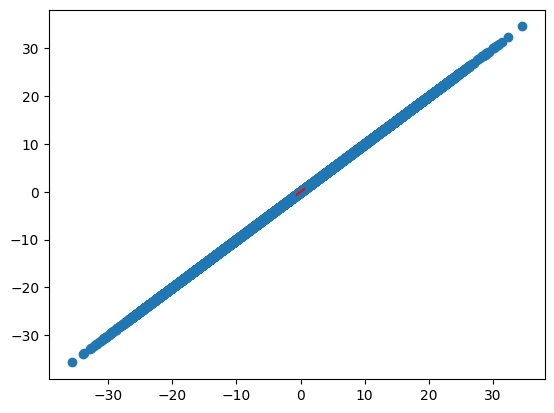

In [12]:
import matplotlib.pyplot as plt



plt.scatter(keras_logits.flatten(), torch_logits.detach().numpy().flatten())
plt.plot([-0.6, 0.6], [-0.6, 0.6], c='r')

In [13]:
he = HydrAMPEncoderTorch()

In [14]:
hydramp_encoder_dict = {
    'embedding.weight': torch.Tensor(encoder_model.layers[1].get_weights()[0]),
    'gru1_f.kernel': torch.Tensor(encoder_model.layers[2].get_weights()[0]),
    'gru1_f.recurrent_kernel': torch.Tensor(encoder_model.layers[2].get_weights()[1]), 
    'gru1_f.bias': torch.Tensor(encoder_model.layers[2].get_weights()[2]), 
    'gru1_r.kernel': torch.Tensor(encoder_model.layers[2].get_weights()[3]),
    'gru1_r.recurrent_kernel': torch.Tensor(encoder_model.layers[2].get_weights()[4]),
    'gru1_r.bias': torch.Tensor(encoder_model.layers[2].get_weights()[5]),
    'gru2_f.kernel': torch.Tensor(encoder_model.layers[3].get_weights()[0]),
    'gru2_f.recurrent_kernel': torch.Tensor(encoder_model.layers[3].get_weights()[1]), 
    'gru2_f.bias': torch.Tensor(encoder_model.layers[3].get_weights()[2]), 
    'gru2_r.kernel': torch.Tensor(encoder_model.layers[3].get_weights()[3]),
    'gru2_r.recurrent_kernel': torch.Tensor(encoder_model.layers[3].get_weights()[4]),
    'gru2_r.bias': torch.Tensor(encoder_model.layers[3].get_weights()[5]),
    'mean_linear.weight': torch.Tensor(encoder_model.layers[4].get_weights()[0].T),
    'mean_linear.bias': torch.Tensor(encoder_model.layers[4].get_weights()[1]),
    'std_linear.weight': torch.Tensor(encoder_model.layers[5].get_weights()[0].T),
    'std_linear.bias': torch.Tensor(encoder_model.layers[5].get_weights()[1]),
}

In [15]:
he.load_state_dict(hydramp_encoder_dict)

<All keys matched successfully>

In [16]:
random_encoder_input = np.random.randint(low=0, high=21, size=(10, 25), dtype='int')
random_encoder_input_torch = torch.Tensor(random_encoder_input).to(torch.int)

In [17]:
current_encoder_mean_model = Model(inputs=input_to_encoder, outputs=encoder_model.layers[4].get_output_at(0))
current_encoder_std_model = Model(inputs=input_to_encoder, outputs=encoder_model.layers[5].get_output_at(0))

In [18]:
he_output_mean, he_output_std = he(random_encoder_input_torch)
he_keras_output_mean = current_encoder_mean_model.predict(random_encoder_input)
he_keras_output_std = current_encoder_std_model.predict(random_encoder_input)

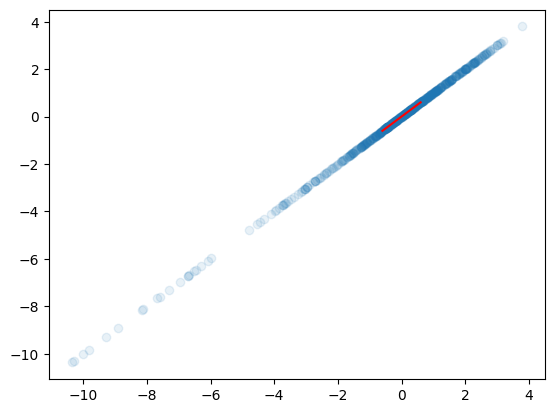

In [19]:
plt.scatter(he_keras_output_mean.flatten(), he_output_mean.detach().numpy().flatten(), alpha=0.1)
plt.plot([-0.6, 0.6], [-0.6, 0.6], c='r', alpha=1)

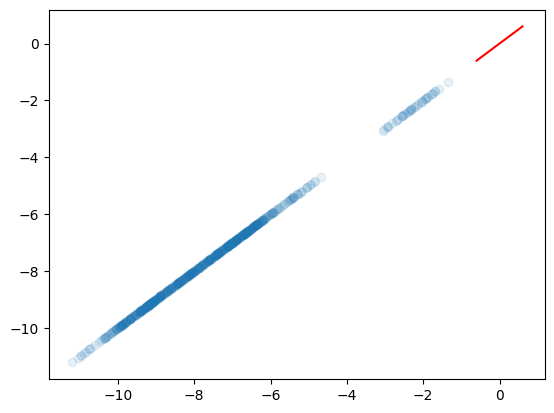

In [20]:
plt.scatter(he_keras_output_std.flatten(), he_output_std.detach().numpy().flatten(), alpha=0.1)
plt.plot([-0.6, 0.6], [-0.6, 0.6], c='r', alpha=1)

In [21]:
#Uncomment if you want to save weights.

#torch.save(hd.state_dict(), 'decoder_weights.pickle')
#torch.save(he.state_dict(), 'encoder_weights.pickle')